In [1]:
# Import Libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load Results
results_path = 'results/spectral_results.csv'
df = pd.read_csv(results_path)

### **1. Obtain Best Spectral Clustering Configuration**

In [3]:
# Convert numerical columns to float
numeric_cols = ['Silhouette', 'ARI', 'DBI', 'Purity', 'Time (s)']
df_all = pd.read_csv('results/spectral_results.csv')
df_all[numeric_cols] = df_all[numeric_cols].astype(float)

# List of datasets
datasets = ['satimage', 'splice', 'vowel']

# Define metrics and whether to maximize them
metrics_info = {
    'Silhouette': True,  # Higher is better
    'ARI': True,         # Higher is better
    'DBI': False,        # Lower is better
    'Purity': True,      # Higher is better
}

# Dictionary to store the best configurations
best_configs = {dataset: {} for dataset in datasets}

# Loop through each dataset
for dataset in datasets:
    # Select only the rows corresponding to the current dataset
    df = df_all[df_all['Dataset'] == dataset].copy()

    # Iterate through each metric
    for metric, maximize in metrics_info.items():
        if maximize:
            # Find the row with the maximum metric value
            best_row = df.loc[df[metric].idxmax()]
        else:
            # Find the row with the minimum metric value
            best_row = df.loc[df[metric].idxmin()]

        # Extract the best parameters
        best_n_neighbors = best_row['N Neighbors']
        best_affinity = best_row['Affinity']
        best_eigen_solver = best_row['Eigen Solver']
        best_assign_labels = best_row['Assign Labels']
        best_n_clusters = best_row['N Clusters']
        best_seed = best_row['Seed']
            
        # Store the best configuration for the current dataset and metric
        best_configs[dataset][metric] = {
            'N Neighbors': best_n_neighbors,
            'Affinity': best_affinity,
            'Eigen Solver': best_eigen_solver,
            'Assign Labels': best_assign_labels,
            'N Clusters': best_n_clusters,
            'Seed': best_seed,
            'Metric Value': best_row[metric]
        }

        # Print the best configuration
        direction = "maximize" if maximize else "minimize"
        print(f"Best configuration for {dataset} based on {metric} ({'higher' if maximize else 'lower'} is better):")
        print(f"  N Neighbors = {best_n_neighbors}")
        print(f"  Affinity = {best_affinity}")
        print(f"  Eigen Solver = {best_eigen_solver}")
        print(f"  Assign Labels = {best_assign_labels}")
        print(f"  N Clusters = {best_n_clusters}")
        print(f"  Seed = {best_seed}")
        print(f"  {metric} = {best_row[metric]}")

        # Print the best configuration (Overleaf)
        print(f"& {metric} & {'NA' if best_affinity == 'rbf' else best_n_neighbors} & {best_affinity} & {best_eigen_solver} & {best_assign_labels} & {best_n_clusters} & {best_row[metric]:.5f}\\\\\n")


Best configuration for satimage based on Silhouette (higher is better):
  N Neighbors = 1
  Affinity = rbf
  Eigen Solver = amg
  Assign Labels = kmeans
  N Clusters = 2
  Seed = 0
  Silhouette = 0.4930660128723531
& Silhouette & NA & rbf & amg & kmeans & 2 & 0.49307\\

Best configuration for satimage based on ARI (higher is better):
  N Neighbors = 10
  Affinity = nearest_neighbors
  Eigen Solver = lobpcg
  Assign Labels = cluster_qr
  N Clusters = 4
  Seed = 2
  ARI = 0.6328838348434659
& ARI & 10 & nearest_neighbors & lobpcg & cluster_qr & 4 & 0.63288\\

Best configuration for satimage based on DBI (lower is better):
  N Neighbors = 3
  Affinity = nearest_neighbors
  Eigen Solver = amg
  Assign Labels = kmeans
  N Clusters = 2
  Seed = 0
  DBI = 0.6378944140269966
& DBI & 3 & nearest_neighbors & amg & kmeans & 2 & 0.63789\\

Best configuration for satimage based on Purity (higher is better):
  N Neighbors = 30
  Affinity = nearest_neighbors
  Eigen Solver = amg
  Assign Labels = clu

### **2. PCA**

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import OPTICS
from sklearn.decomposition import PCA
from preprocessing import DataLoader, DataProcessor
import os

from sklearn.cluster import SpectralClustering

# Define full metric names
metric_full_names = {
    'ARI': 'Adjusted Rand Index Metric',
    'DBI': 'Davies-Bouldin Index Metric',
    'Silhouette': 'Silhouette Score Metric',
    'Purity': 'Purity Score Metric'
}

# Define the order of metrics for plotting
metrics_order = ['ARI', 'DBI', 'Silhouette', 'Purity']

# Define whether to maximize each metric
metrics_info = {
    'ARI': True,         # Higher is better
    'DBI': False,        # Lower is better
    'Silhouette': True,  # Higher is better
    'Purity': True       # Higher is better
}

def visualize_pca_all_datasets(best_configs, datasets, output_dir='pca_plots'):
    """
    Visualizes PCA plots for all datasets and metrics, and combines them into a single image.
    
    Parameters:
    - best_configs (dict): Nested dictionary containing best configurations per dataset and metric.
    - datasets (list): List of dataset names.
    - output_dir (str): Directory to save the PCA plots.
    
    Returns:
    - None
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Initialize loaders and preprocessors once
    data_loader = DataLoader()
    data_processor = DataProcessor()
    
    # Initialize PCA (2 components)
    pca = PCA(n_components=2)

    # Define the layout for the final combined image
    num_datasets = len(datasets)

    # Create a figure with enough subplots
    # Each dataset has a 2x2 grid, arranged horizontally
    fig, axs = plt.subplots(nrows=2, ncols=2 * num_datasets, figsize=(10 * num_datasets, 10))

    # Adjust layout spacing
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    # Add main title
    fig.suptitle("PCA Clustering Results for All Datasets (2x2 Per Dataset)", fontsize=16)
    
    for ds_idx, dataset in enumerate(datasets):
        # Load dataset using custom loader
        data, labels = data_loader.load_arff_data(dataset)
        X = data_processor.preprocess_dataset(data)
        
        # Retrieve all metrics for the specified dataset
        if dataset not in best_configs:
            print(f"Dataset '{dataset}' not found in best_configs. Skipping.")
            continue
        
        dataset_metrics = best_configs[dataset]
        
        for metric_idx, metric in enumerate(metrics_order):
            ax = axs[metric_idx // 2, ds_idx * 2 + metric_idx % 2]
            
            # Check if metric configuration exists
            if metric not in dataset_metrics:
                print(f"Metric '{metric}' not found for dataset '{dataset}'. Skipping.")
                ax.axis('off')
                continue
            
            config = dataset_metrics[metric]
            
            # Extract Spectral Clustering parameters
            try:
                best_n_neighbors = int(config['N Neighbors'])
                best_affinity = config['Affinity']
                best_eigen_solver = config['Eigen Solver']
                best_assign_labels = config['Assign Labels']
                best_n_clusters = int(config['N Clusters'])
                best_seed = int(config['Seed'])
            except KeyError as e:
                print(f"Missing parameter {e} in best_configs for dataset '{dataset}' and metric '{metric}'. Skipping.")
                ax.axis('off')
                continue

            # Apply Spectral Clustering with best parameters
            try:
                spectral = SpectralClustering(eigen_solver=best_eigen_solver, affinity=best_affinity,
                                        n_neighbors=best_n_neighbors, assign_labels=best_assign_labels,
                                        n_clusters=best_n_clusters, random_state=best_seed, n_jobs=1)
                y_pred = spectral.fit_predict(X)
            except Exception as e:
                print(f"Error applying SpectralClustering for dataset '{dataset}' and metric '{metric}': {e}")
                ax.axis('off')
                continue
            
            # Perform PCA
            try:
                X_pca = pca.fit_transform(X)
            except Exception as e:
                print(f"Error performing PCA for dataset '{dataset}' and metric '{metric}': {e}")
                ax.axis('off')
                continue
            
            # Calculate the percentage of variance explained by each component
            variance_ratio = pca.explained_variance_ratio_
            pc1_var = variance_ratio[0] * 100
            pc2_var = variance_ratio[1] * 100

            # Plotting using seaborn's scatterplot
            try:
                sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_pred, palette='tab10', ax=ax, s=50, alpha=0.8, legend=False)
            except Exception as e:
                print(f"Error plotting scatterplot for dataset '{dataset}' and metric '{metric}': {e}")
                ax.axis('off')
                continue

            ax.set_title(metric_full_names.get(metric, metric), fontsize=12)

            # Update axis labels to include percentage of variance explained
            ax.set_xlabel(f'Principal Component 1 ({pc1_var:.1f}% Variance)')
            ax.set_ylabel(f'Principal Component 2 ({pc2_var:.1f}% Variance)')
    
        # Add dataset title spanning its 2 columns
        fig.text((ds_idx + 0.5) / num_datasets, 0.9, f'{dataset.capitalize()} Dataset', ha='center', va='center', fontsize=14, fontweight='bold')
        
    # Show the combined figure
    plt.tight_layout(rect=[0, 0, 1, 0.93])  # Adjust rect to make room for the main title
    plt.show()

c:\Users\joanc\Desktop\IML\.venv\lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\joanc\Desktop\IML\.venv\lib\site-packages\sklearn\manifold\_spectral_embedding.py:393: UserWarning: Exited at iteration 20 with accuracies 
[4.74854313e-16 7.56195634e-06 1.47712436e-05 3.58357367e-05
 4.09144205e-04]
not reaching the requested tolerance 4.4792890548706055e-05.
Use iteration 21 instead with accuracy 
9.346262828414298e-05.

  _, diffusion_map = lobpcg(laplacian, X, M=M, tol=tol, largest=False)
c:\Users\joanc\Desktop\IML\.venv\lib\site-packages\sklearn\manifold\_spectral_embedding.py:393: UserWarning: Exited postprocessing with accuracies 
[4.64904572e-16 7.56195634e-06 1.47712436e-05 3.58357367e-05
 4.09144205e-04]
not reaching the requested tolerance 4.4792890548706055e-05.
  _, diffusion_map = lobpcg(laplacian, X, M=M, tol=tol, largest=False)


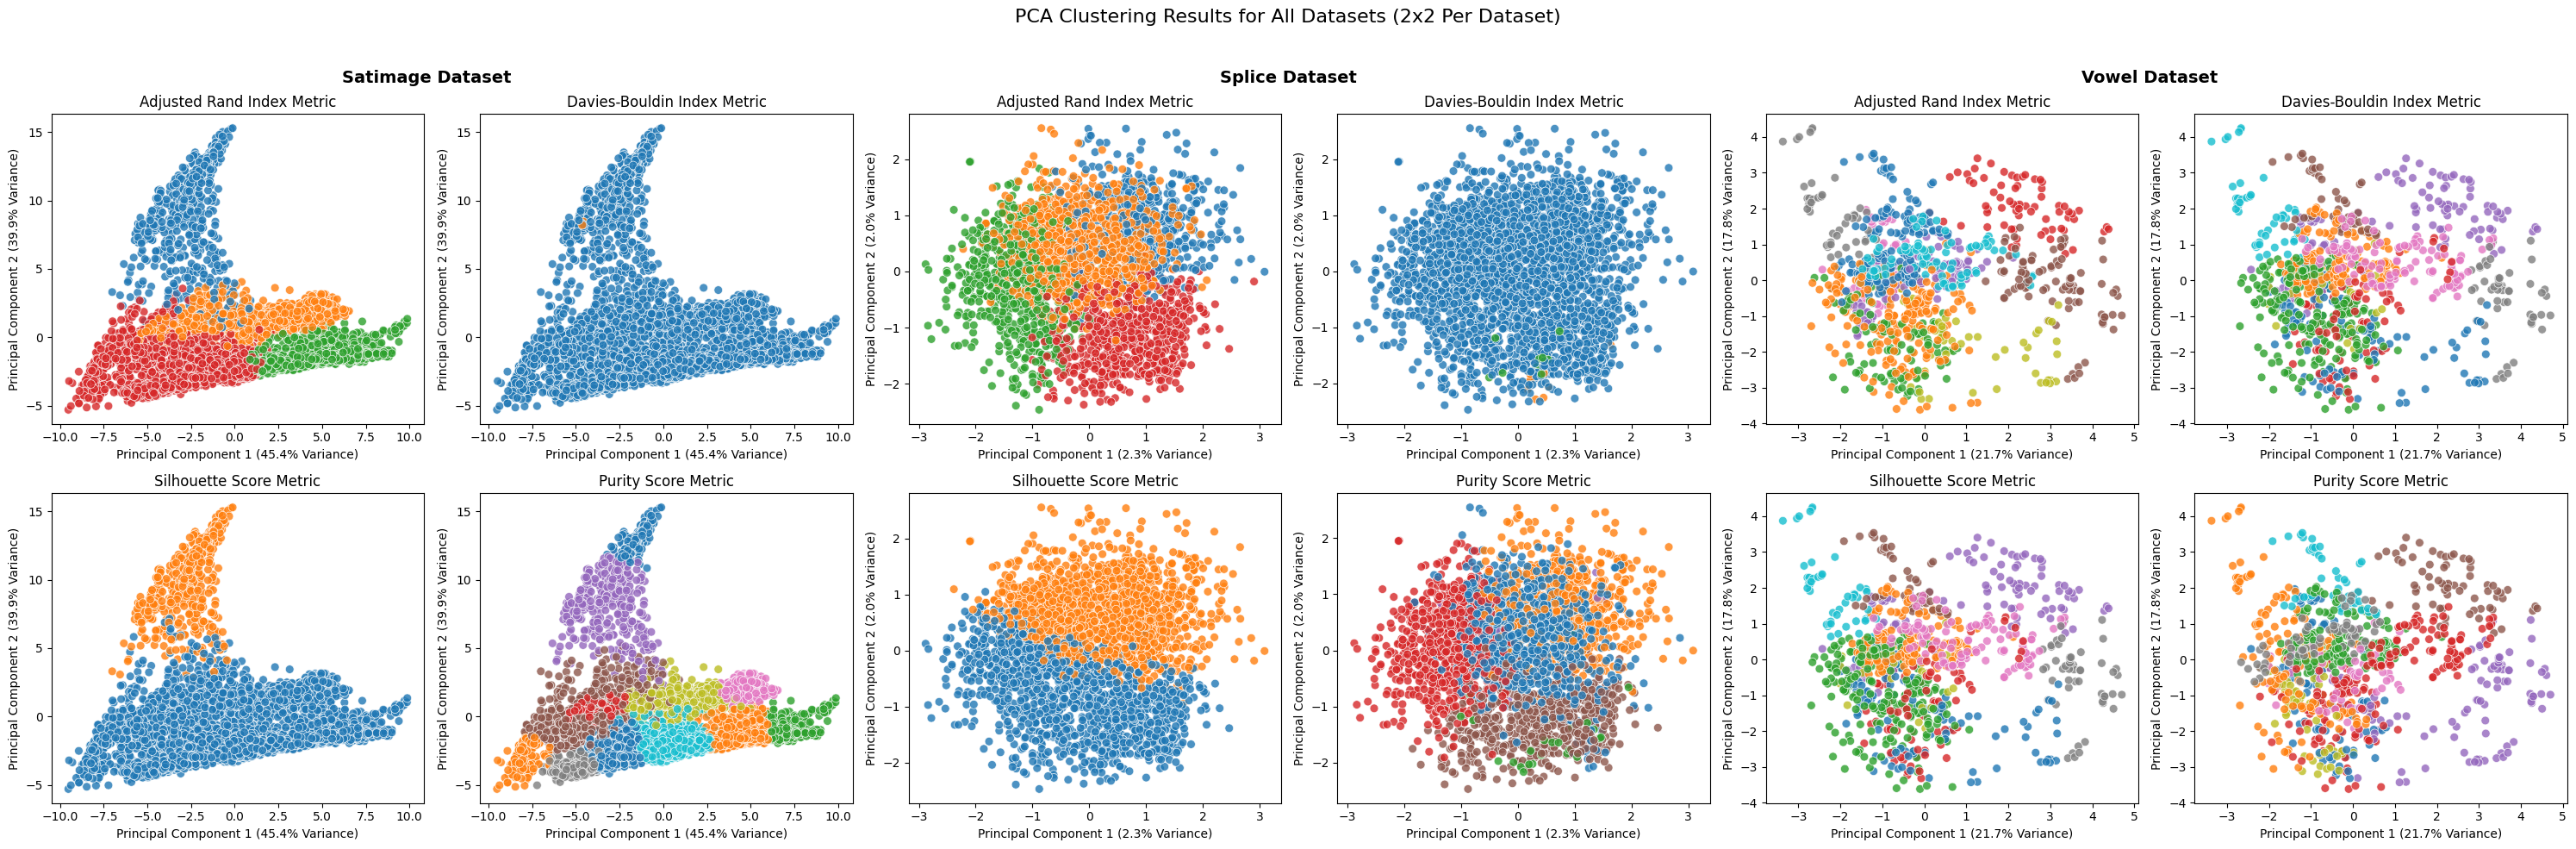

In [8]:
visualize_pca_all_datasets(best_configs, ['satimage', 'splice', 'vowel'])

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import SpectralClustering
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
import numpy as np
import os
from preprocessing import DataLoader, DataProcessor

# Define full metric names
metric_full_names = {
    'ARI': 'Adjusted Rand Index Metric',
    'DBI': 'Davies-Bouldin Index Metric',
    'Silhouette': 'Silhouette Score Metric',
    'Purity': 'Purity Score Metric'
}

# Define the order of metrics for plotting
metrics_order = ['ARI', 'DBI', 'Silhouette', 'Purity']

# Define whether to maximize each metric
metrics_info = {
    'ARI': True,         # Higher is better
    'DBI': False,        # Lower is better
    'Silhouette': True,  # Higher is better
    'Purity': True       # Higher is better
}

def visualize_confusion_matrices_all_datasets(best_configs, datasets, output_dir='confusion_matrices'):
    """
    Visualizes confusion matrices for all datasets and metrics, and combines them into a single image.
    
    Parameters:
    - best_configs (dict): Nested dictionary containing best configurations per dataset and metric.
    - datasets (list): List of dataset names.
    - output_dir (str): Directory to save the confusion matrix plots.
    
    Returns:
    - None
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Initialize loaders and preprocessors once
    data_loader = DataLoader()
    data_processor = DataProcessor()

    # Initialize figure and axes
    num_datasets = len(datasets)
    metrics_per_dataset = len(metrics_order)

    # Create a figure with enough subplots
    # Each dataset has a 2x2 grid, arranged horizontally
    fig, axs = plt.subplots(nrows=2, ncols=2 * num_datasets, figsize=(10 * num_datasets, 10))

    # Adjust layout spacing
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    # Add main title
    fig.suptitle("Confusion Matrices for All Datasets (2x2 Per Dataset)", fontsize=16)

    for ds_idx, dataset in enumerate(datasets):
        # Load dataset using custom loader
        data, labels = data_loader.load_arff_data(dataset)
        X = data_processor.preprocess_dataset(data)
        y_true = labels

        # Retrieve all metrics for the specified dataset
        if dataset not in best_configs:
            print(f"Dataset '{dataset}' not found in best_configs. Skipping.")
            continue

        dataset_metrics = best_configs[dataset]

        for metric_idx, metric in enumerate(metrics_order):
            ax = axs[metric_idx // 2, ds_idx * 2 + metric_idx % 2]

            # Check if metric configuration exists
            if metric not in dataset_metrics:
                print(f"Metric '{metric}' not found for dataset '{dataset}'. Skipping.")
                ax.axis('off')
                continue

            config = dataset_metrics[metric]

            # Extract Spectral Clustering parameters
            try:
                best_n_neighbors = int(config['N Neighbors'])
                best_affinity = config['Affinity']
                best_eigen_solver = config['Eigen Solver']
                best_assign_labels = config['Assign Labels']
                best_n_clusters = int(config['N Clusters'])
                best_seed = int(config.get('Seed', 42))  # Use default seed if not present
            except KeyError as e:
                print(f"Missing parameter {e} in best_configs for dataset '{dataset}' and metric '{metric}'. Skipping.")
                ax.axis('off')
                continue

            # Apply Spectral Clustering with best parameters
            try:
                spectral = SpectralClustering(
                    n_clusters=best_n_clusters,
                    eigen_solver=best_eigen_solver,
                    affinity=best_affinity,
                    n_neighbors=best_n_neighbors,
                    assign_labels=best_assign_labels,
                    random_state=best_seed,
                    n_jobs=1
                )
                y_pred = spectral.fit_predict(X)
            except Exception as e:
                print(f"Error applying SpectralClustering for dataset '{dataset}' and metric '{metric}': {e}")
                ax.axis('off')
                continue

            # Compute confusion matrix
            try:
                # Map true labels and predicted labels to consecutive integers
                y_true_unique = np.unique(y_true)
                y_pred_unique = np.unique(y_pred)

                y_true_mapping = {label: idx for idx, label in enumerate(y_true_unique)}
                y_pred_mapping = {label: idx for idx, label in enumerate(y_pred_unique)}

                y_true_mapped = np.array([y_true_mapping[label] for label in y_true])
                y_pred_mapped = np.array([y_pred_mapping[label] for label in y_pred])

                # Compute confusion matrix
                cm = confusion_matrix(y_true_mapped, y_pred_mapped)

                # Apply the Hungarian algorithm to find the best assignment
                cost_matrix = cm.max() - cm  # Convert to cost matrix for maximization
                row_ind, col_ind = linear_sum_assignment(cost_matrix)

                # Reorder the confusion matrix
                cm_reordered = cm[:, col_ind]

                # Remove rows and columns that sum to 0
                non_zero_rows = np.any(cm_reordered > 0, axis=1)
                non_zero_cols = np.any(cm_reordered > 0, axis=0)
                cm_reordered = cm_reordered[non_zero_rows, :][:, non_zero_cols]

                # Normalize confusion matrix to [0,1]
                cm_row_sums = cm_reordered.sum(axis=1, keepdims=True)
                cm_row_sums[cm_row_sums == 0] = 1  # Avoid division by zero
                cm_normalized = cm_reordered.astype('float') / cm_row_sums

                # Generate labels for heatmap axes
                true_labels_names = [str(y_true_unique[i]) for i in range(len(y_true_unique)) if non_zero_rows[i]]
                pred_labels_names = [str(y_pred_unique[col_ind[j]]) for j in range(len(col_ind)) if non_zero_cols[j]]

                # Plot confusion matrix
                sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=ax,
                            xticklabels=pred_labels_names, yticklabels=true_labels_names, cbar=False)
                ax.set_title(metric_full_names.get(metric, metric), fontsize=12)
                ax.set_xlabel('Predicted Cluster')
                ax.set_ylabel('True Label')
            except Exception as e:
                print(f"Error computing or plotting confusion matrix for dataset '{dataset}' and metric '{metric}': {e}")
                ax.axis('off')
                continue

        # Add dataset title spanning its 2 columns
        fig.text((ds_idx + 0.5) / num_datasets, 0.9, f'{dataset.capitalize()} Dataset', ha='center', va='center', fontsize=14, fontweight='bold')

    # Save the combined figure
    plt.tight_layout(rect=[0, 0, 1, 0.93])  # Adjust rect to make room for the main title
    plt.show()


c:\Users\joanc\Desktop\IML\.venv\lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\joanc\Desktop\IML\.venv\lib\site-packages\sklearn\manifold\_spectral_embedding.py:393: UserWarning: Exited at iteration 20 with accuracies 
[4.66542990e-16 7.54694712e-06 1.47473474e-05 3.57582818e-05
 4.09394558e-04]
not reaching the requested tolerance 4.4792890548706055e-05.
Use iteration 21 instead with accuracy 
9.348942694869077e-05.

  _, diffusion_map = lobpcg(laplacian, X, M=M, tol=tol, largest=False)
c:\Users\joanc\Desktop\IML\.venv\lib\site-packages\sklearn\manifold\_spectral_embedding.py:393: UserWarning: Exited postprocessing with accuracies 
[4.71715023e-16 7.54694712e-06 1.47473474e-05 3.57582818e-05
 4.09394558e-04]
not reaching the requested tolerance 4.4792890548706055e-05.
  _, diffusion_map = lobpcg(laplacian, X, M=M, tol=tol, largest=False)


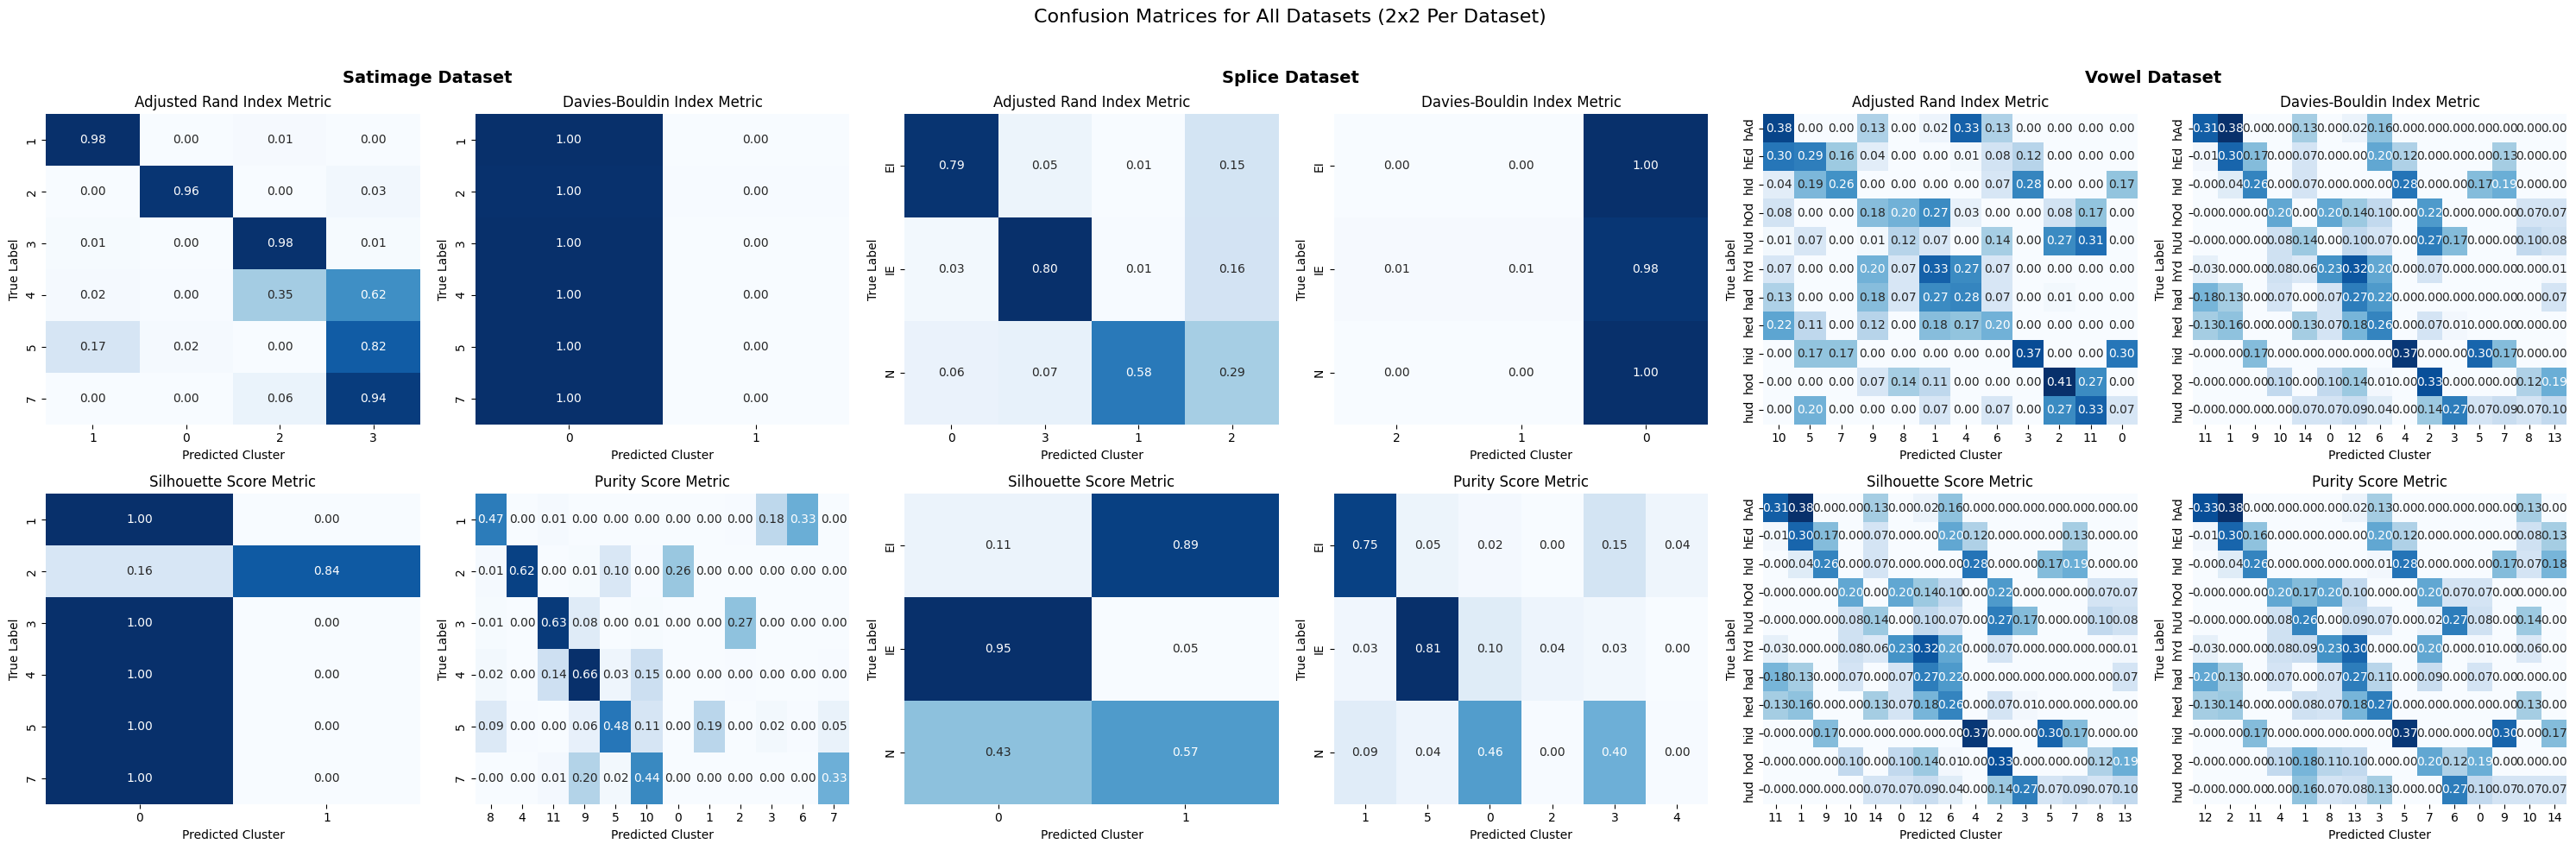

In [11]:
visualize_confusion_matrices_all_datasets(best_configs, ['satimage', 'splice', 'vowel'])

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from preprocessing import DataLoader, DataProcessor

def visualize_true_PCA(datasets):
    """
    Visualizes PCA plots for all datasets based on true labels.

    Parameters:
    - datasets (list): List of dataset names.

    Returns:
    - None
    """
    
    # Initialize loaders and preprocessors once
    data_loader = DataLoader()
    data_processor = DataProcessor()
    
    # Initialize PCA (2 components)
    pca = PCA(n_components=2)
    
    # Define the layout for the final combined image
    num_datasets = len(datasets)
    
    # Determine the number of columns based on datasets
    cols = num_datasets
    rows = 1  # Single row for simplicity; adjust if more complex layouts are needed
    
    # Create a figure with subplots
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(6 * cols, 5))
    
    # If there's only one dataset, axs may not be an array
    if num_datasets == 1:
        axs = [axs]
    else:
        axs = axs.flatten()
    
    for idx, dataset in enumerate(datasets):
        ax = axs[idx]
        
        # Load dataset using custom loader
        try:
            data, labels = data_loader.load_arff_data(dataset)
            X = data_processor.preprocess_dataset(data)
        except Exception as e:
            print(f"Error loading or preprocessing dataset '{dataset}': {e}")
            ax.axis('off')
            continue
        
        # Perform PCA
        try:
            X_pca = pca.fit_transform(X)
        except Exception as e:
            print(f"Error performing PCA for dataset '{dataset}': {e}")
            ax.axis('off')
            continue
        
        # Calculate the percentage of variance explained by each component
        variance_ratio = pca.explained_variance_ratio_
        pc1_var = variance_ratio[0] * 100
        pc2_var = variance_ratio[1] * 100
        
        # Plotting using seaborn's scatterplot
        sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='tab10', 
            ax=ax, s=50, alpha=0.8, legend='full'
        )
        
        ax.set_title(f"{dataset.capitalize()} Dataset", fontsize=14, fontweight='bold')
        ax.set_xlabel(f'Principal Component 1 ({pc1_var:.1f}% Variance)')
        ax.set_ylabel(f'Principal Component 2 ({pc2_var:.1f}% Variance)')
        ax.legend(title='True Labels', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust layout spacing
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)  # Make room for the main title
    
    # Add main title
    fig.suptitle("PCA Visualization of Datasets with True Labels", fontsize=16)

    # Show the combined figure
    plt.show()


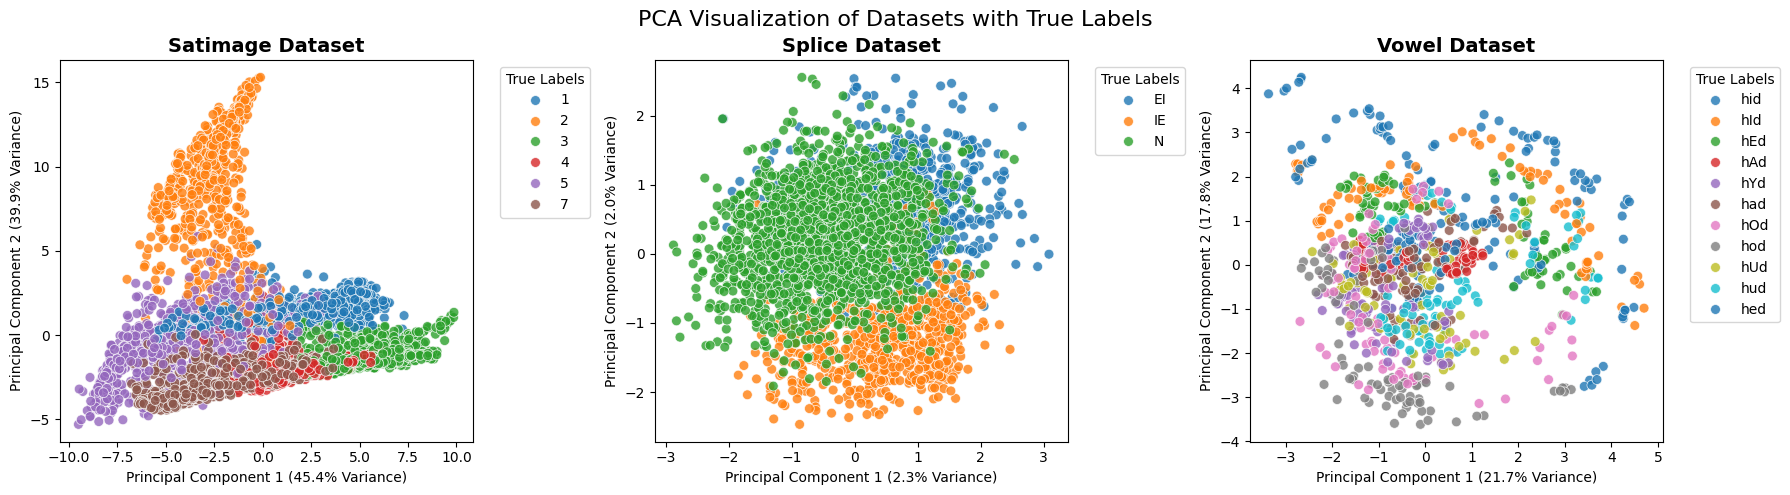

In [14]:
visualize_true_PCA(datasets)